In [151]:
# CELL 1

# Synapse Classification Challenge
# Introduction to Connectomics 
# Wednesday, January 17, 2018
# Brandon T. Lim (blim8)
# Github: blim747

your_name = 'lim_brandon'

In [152]:
# CELL 2

# Load data

import numpy as np

!pip install mahotas
!pip install ndparse
%matplotlib inline

data = np.load('./synchallenge2017_training.npz')

imtrain = data['imtrain']
annotrain = data['annotrain']
ytrain = data['ytrain']

data = np.load('./synchallenge2017_validation.npz')

imvalid = data['imvalid']
annovalid = data['annovalid']
yvalid = data['yvalid']

In [153]:
# CELL 3

#this is where the work is done!

# Define feature extraction code

# entropy

# ravel makes a n dimensional array into a 1 d array
# flatten makes an n dimensional array into a 1 d array

import skimage.feature as skif

def extract_features(imdata):
    xtrain = []
    for im in imdata:
        fvector = []
        # 50th percentile based on intensity
        fvector.append(np.percentile(im,50))

        # add a contrast feature
        g = skif.greycomatrix(im, [1, 2], [0, np.pi / 2],normed=True, symmetric=True)
        homogeneity = skif.greycoprops(g, 'homogeneity')

        # explict way to add feature elements one at a time
        homogeneity = np.ravel(homogeneity)

        for i in homogeneity:
            fvector.append(i)
        
        # NEW FEATURE: examined contrast using greycoprops
                
        contrast = skif.greycoprops(g, 'contrast')
        
        contrast = np.ravel(contrast)
        
        for k in contrast:
            fvector.append(k)
        
        # NEW FEATURE: using hog (Histogram of Oriented Gradients)
        # CHANGED DEFAULT VARIABLES: the tuple (16, 16) is by default (9,9)
        #                            the tuple (4, 4) is by default (3,3)
        hogImg = skif.hog(im, 9, (16, 16), (4,4))
        hogImg = np.ravel(hogImg)
        
        for h in hogImg:  
            fvector.append(h)
            
        # NEW FEATURE: local_binary_pattern
        lbp = skif.local_binary_pattern(im, 3, 24, 'nri_uniform')
        lbp = np.ravel(lbp)
        
        for d in lbp:
            fvector.append(d)
        
        
        fvector = np.asarray(fvector)
        # print(fvector)
        xtrain.append(fvector)

    output = np.asarray(xtrain)
    # print (output)
    return output
    

In [154]:
# CELL 4

# Extract Features from training

xtrain = extract_features(imtrain)
# Train Classifier

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(xtrain, ytrain)


In [155]:
# CELL 5

# Extract features from validation set
xvalid = extract_features(imvalid)

In [156]:
# CELL 6

# Run Classifier on validation set
scoresvalid = clf.predict_proba(xvalid)

In [157]:
# CELL 7

# Best f1 score report on validation set

from sklearn.metrics import f1_score

# Can add post-processing here if desired

prob_syn = scoresvalid[:,1]

# default threshold
print('default f1 score: {}'.format(np.round(f1_score(yvalid, prob_syn >=0.5),2)))

f1_out = 0
thresh = 0
for i in np.arange(0.0, 1, 0.05):
    f1_test =  f1_score(yvalid, prob_syn > i)
    if f1_test > f1_out:
        f1_out = f1_test
        thresh = i

print('My best validation f1-score is: {} at {} threshold.'.format(np.round(f1_out,2), thresh))

default f1 score: 0.86
My best validation f1-score is: 0.86 at 0.5 threshold.


synapse present - true positive


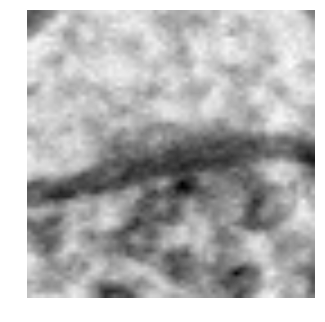

no synapse present - true negative


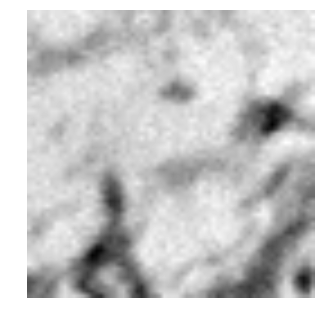

synapse present - false negative


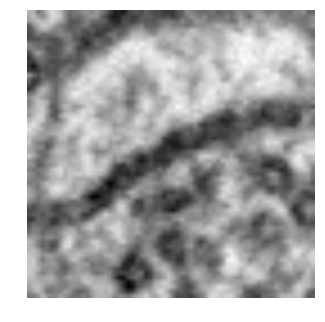

no synapse present - false positive


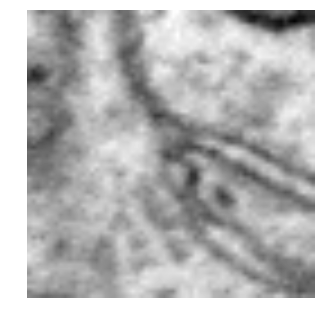

In [158]:
# CELL 8

# here we can inspect results

valid_labels = np.asarray(prob_syn > thresh,dtype='int')
# find images we did well on
idx_correct_syn = np.where((valid_labels == yvalid) & (yvalid == 1))[0]
idx_correct_nosyn = np.where((valid_labels == yvalid) & (yvalid == 0))[0]
# find images we did poorly on

idx_wrong_syn = np.where((valid_labels != yvalid) & (yvalid == 1))[0]
idx_wrong_nosyn = np.where((valid_labels != yvalid) & (yvalid == 0))[0]
import ndparse as ndp

print('synapse present - true positive')
ndp.plot(imvalid[idx_correct_syn[3]])

print('no synapse present - true negative')
ndp.plot(imvalid[idx_correct_nosyn[3]])

print('synapse present - false negative')
ndp.plot(imvalid[idx_wrong_syn[3]])

print('no synapse present - false positive')
ndp.plot(imvalid[idx_wrong_nosyn[3]])

In [159]:
# CELL 9

# Validate performance on test set (should only run/score once!)

data = np.load('./synchallenge2017_test_notruth.npz')

imtest = data['imtest']
annotest = data['annotest']

# Extract features from test set
xtest = extract_features(imtest)

# Run classifier on test set
scoretest = clf.predict_proba(xvalid)

# Post-processing
prob_syntest = scoretest[:,1]
syntest_predict = prob_syntest > thresh
syntest_predict = np.asarray(syntest_predict,dtype = 'uint8')

# save file and upload to google docs with label vector
np.save(your_name+'_synchallenge_testdata.npy',syntest_predict)

<!--CELL 10-->

<h1>THIS IS BRANDON LIM'S PARAGRAPH WRITE UP:</h1>

<p>I really enjoyed this assignment. My one complaint about it is that while it is cool to experiment with machine learning, I have no idea what is going on behind the scenes. I wish I had some understanding what it means to get a "histograph oriented gradients" for example. Of course, this probably requires lots of advanced math that I do not currently possess right now.</p>
<p>When I ran this notebook with the new features I received a f1 score of 0.86, which is above the 0.8 required for the assignment. I will explain my reasoning for adding the three new features and the change I made from the default parameters:</p>
<ol>
<li><b>Using graycoprops('contrast'):</b> When examining the true positives and true negatives, I noticed a difference in the amount of contrast (the sharpness between a dark color and white color). This was the first new feature I added because I used the code for graycoprops('homogeneity') that was given. This is the only feature I added due to examining the results of my classifier.</li>
<li><b>Using hog with changed tuple values:</b> I originally chose to use the hog feature because when I searched for the word "feature vector" in the scikit-image documentation, the only time those words appeared was in the description for the hog feature. When I used it, I noticed a big jump in my f1 score, so I kept it. I changed the tuple value parameters because when I ran it with the default, I got an error after running cell 7. The code still ran, it just gave me a warning about how some prediction values were 0 or something like that. Just by experimenting I discovered that when I changed the tuple values to their current numbers the warning went away.</li>
<li><b>Using local_binary_pattern:</b> I chose this feature because it was one of the few other features that returned a two dimensional array, which I was familiar with using from implementing the hog feature. The parameters are set to what they are because of a tutorial I found that uses this feature.</li>
</ol>
<p>My submission fulfills the full marks outlined in the rubric: </p>
<ul>
<li>I implemented three new features and two new functions from the scikit-image library</li>
<li>I changed the default parameters of one function</li>
<li>My f1 score is greater than 0.8</li>
<li>I wrote this writeup (formatted with HTML)</li>
<li>Code does not break</li>
<li>And I wrote my name on the assignment.</li>
</ul>
     